In [1]:
import numpy as np
import random
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
height_limit=30
trees_in_forest=100

In [3]:
class Node:
    def __init__(self,attribute,threshold,left,right):
        self.attribute=attribute
        self.threshold=threshold
        self.left=left
        self.right=right
    
    def get_attribute(self):
        return self.attribute
    
    def get_threshold(self):
        return self.threshold
    
    def get_left(self):
        return self.left
    
    def get_right(self):
        return self.right

Creating an Isolation Tree


In [4]:
def create_itree(X, curr_height, height_limit):
    if curr_height == 0:
        q_idx = random.randint(0, X.shape[1] - 1)
        p = random.uniform(X.iloc[:, q_idx].min(), X.iloc[:, q_idx].max())
        X_left = X.iloc[:, q_idx] < p
        X_right = X.iloc[:, q_idx] >= p
        head = Node(attribute=q_idx, threshold=p, left=create_itree(X[X_left], curr_height=curr_height + 1, height_limit=height_limit), right=create_itree(X[X_right], curr_height=curr_height + 1, height_limit=height_limit))
        return head

    elif curr_height >= height_limit or X.shape[0] <= 1:
        return Node(attribute=None, threshold=None, left=None, right=None)

    else:
        q_idx = random.randint(0, X.shape[1] - 1)
        p = random.uniform(X.iloc[:, q_idx].min(), X.iloc[:, q_idx].max())
        X_left = X.iloc[:, q_idx] < p
        X_right = X.iloc[:, q_idx] >= p
        mid_node = Node(attribute=q_idx, threshold=p, left=create_itree(X[X_left], curr_height=curr_height + 1, height_limit=height_limit), right=create_itree(X[X_right], curr_height=curr_height + 1, height_limit=height_limit))
        return mid_node


Creating an Isolation Forest

In [5]:
def create_iforest(height_limit,trees,X):
    nodes=[]
    cnt=0
    for i in range(trees):
        
        node=create_itree(X=X,height_limit=height_limit,curr_height=0)
        nodes.append(node)
    return nodes

Finding average Height of Each node in the test dataset

In [6]:
def height_calculation(X, height_limit, trees, nodes):
    avg_height = np.zeros(X.shape[0])
    cnt=0
    for head in nodes:
        
        for i in range(avg_height.shape[0]):
            
            curr_height = 0
            current_node = head
            while current_node is not None:
                if current_node.get_attribute() is None:
                    avg_height[i] += curr_height
                    break
                elif X.iloc[i, current_node.get_attribute()] < current_node.get_threshold():
                    curr_height += 1
                    current_node = current_node.get_left()
                else:
                    curr_height += 1
                    current_node = current_node.get_right()
    avg_height /= trees
    return avg_height

Extracting the data

In [7]:
df = pd.read_csv('creditcard.csv')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
seed = 1337

def get_data(df, clean_train=True):
   
    clean = df[df.Class == 0].copy().reset_index(drop=True)
    fraud = df[df.Class == 1].copy().reset_index(drop=True)
    print(f'Clean Samples: {len(clean)}, Fraud Samples: {len(fraud)}')

    if clean_train:
        train, test_clean = train_test_split(clean, test_size=len(fraud), random_state=seed)
        print(f'Train Samples: {len(train)}')

        test = pd.concat([test_clean, fraud]).reset_index(drop=True)

        print(f'Test Samples: {len(test)}')

        # shuffle the test data
        test.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        train_X, train_y = train.loc[:, ~train.columns.isin(['Class'])], train.loc[:, train.columns.isin(['Class'])]
        test_X, test_y = test.loc[:, ~test.columns.isin(['Class'])], test.loc[:, test.columns.isin(['Class'])]
    else:
        clean_train, clean_test = train_test_split(clean, test_size=int(len(fraud)+(len(fraud)*0.9)), random_state=seed)
        fraud_train, fraud_test = train_test_split(fraud, test_size=int(len(fraud)*0.1), random_state=seed)
        
        train_samples = pd.concat([clean_train, fraud_train]).reset_index(drop=True)
        test_samples = pd.concat([clean_test, fraud_test]).reset_index(drop=True)
        
        # shuffle
        train_samples.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        print(f'Train Samples: {len(train_samples)}')
        test_samples.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        print(f'Test Samples: {len(test_samples)}')
        train_X, train_y = train_samples.loc[:, ~train_samples.columns.isin(['Class'])], train_samples.loc[:, train_samples.columns.isin(['Class'])]
        test_X, test_y = test_samples.loc[:, ~test_samples.columns.isin(['Class'])], test_samples.loc[:, test_samples.columns.isin(['Class'])]
    
    return train_X, train_y, test_X, test_y

train_X, train_y, test_X, test_y = get_data(df)

Clean Samples: 284315, Fraud Samples: 492
Train Samples: 283823
Test Samples: 984


In [9]:
forest=create_iforest(height_limit=height_limit,trees=trees_in_forest,X=train_X)

After Creating Forest, we can now start measuring the distance for testing cases

In [10]:
height_array=height_calculation(X=test_X,height_limit=height_limit,trees=trees_in_forest,nodes=forest)

In [11]:
print(height_array.shape)

(984,)


In [12]:
sorted_indices = np.argsort(height_array)
sorted_y_pred = height_array[sorted_indices]
sorted_y = test_y.iloc[sorted_indices]

##setting threshold=28.78
y_pred=np.zeros(height_array.shape[0])
for i in range(height_array.shape[0]):
    if height_array[i]<28.78:
        y_pred[i]=1
    else:
        y_pred[i]=0

##calculating accuracy:
acc=0
for i in range(y_pred.shape[0]):
    if(y_pred[i]==test_y.iloc[i].values):
        acc=acc+1

print("Accuracy:", acc/height_array.shape[0])

Accuracy: 0.9146341463414634


In [13]:
TP=0
TN=0
FP=0
FN=0

for i in range(y_pred.shape[0]):
    if y_pred[i]==test_y.iloc[i].values and y_pred[i]==1:
        TN=TN+1
    elif y_pred[i]==test_y.iloc[i].values and y_pred[i]==0:
        TP=TP+1
    elif y_pred[i]!=test_y.iloc[i].values and y_pred[i]==0:
        FP=FP+1
    else:
        FN=FN+1

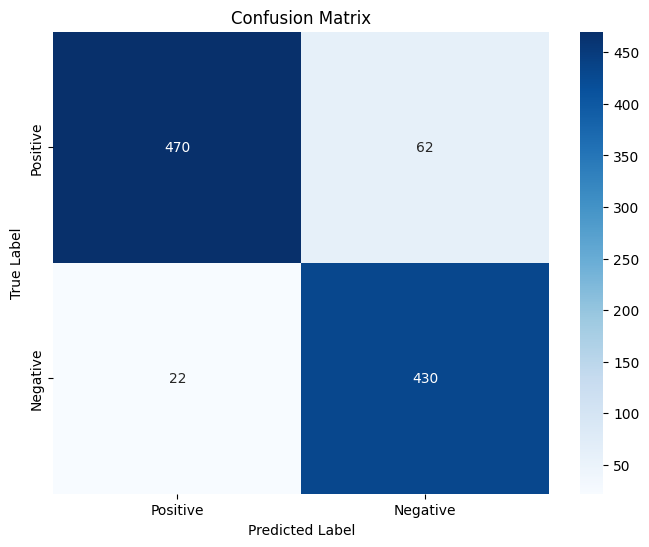

In [14]:
conf_matrix = np.array([[TP, FP],
                        [FN, TN]])


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Positive', 'Negative'], 
            yticklabels=['Positive', 'Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [15]:
print("Precision:", TP/(TP+FP))
print("Recall:", TP/(TP+FN))
print("F1_Score:", (2*TP)/((2*TP)+FP+FN))
print("Accuracy:", (TP+TN)/(TP+TN+FP+FN))

Precision: 0.8834586466165414
Recall: 0.9552845528455285
F1_Score: 0.91796875
Accuracy: 0.9146341463414634
